## Assignment: Dataset Selection and Preparation

**Dataset:** Sentiment140 (1.6M tweets)
**Source:** https://www.kaggle.com/datasets/kazanova/sentiment140

**Tasks:**
- Choose dataset
- Clean & preprocess (URLs/HTML/special chars, duplicates, missing values, normalization)
- Report basic statistics
- Create train/validation/test splits

## 1. Import Required Libraries

**Purpose:** Load tools for data handling, text cleaning, NLP, visualization, and splitting.

**Libraries:**
- pandas, numpy
- re, string, Counter
- nltk (tokenization, stopwords, lemmatization)
- matplotlib, seaborn
- sklearn (train/validation/test split)

In [76]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Text processing
import re
import string
from collections import Counter

# NLP libraries
import nltk
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data splitting
from sklearn.model_selection import train_test_split

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Download NLTK Resources

Download: `punkt`, `stopwords`, `wordnet`, `omw-1.4`, `averaged_perceptron_tagger`.

In [77]:
# Download required NLTK data (quiet mode)
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

print("NLTK resources ready.")

NLTK resources ready.


## 3. Load the Dataset

Ensure `Sentiment140.csv` exists in this folder (from the Kaggle file).

**Columns:** `target`, `ids`, `date`, `flag`, `user`, `text`.

In [78]:
from IPython.display import display
# Load the dataset
# Note: The original CSV has no header, so we define column names
column_names = ['target', 'ids', 'date', 'flag', 'user', 'text']

# Load data
df = pd.read_csv('Sentiment140.csv', 
                 encoding='latin-1',  # Handle encoding issues
                 names=column_names,
                 header=None)

print("Dataset loaded successfully!")
print("\nFirst few rows:")

display(df.head().style.set_properties(**{'white-space': 'pre'}))

Dataset loaded successfully!

First few rows:


,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


## 4. Initial Data Exploration

Check shape, data types, missing values, and sentiment distribution.

In [79]:
from IPython.display import display

# Basic information about the dataset
print("="*50)
print("DATASET INFORMATION")
print("="*50)
print(f"\nDataset Shape: {df.shape}")
print(f"Number of rows: {df.shape[0]:,}")
print(f"Number of columns: {df.shape[1]}")

# Combine data types and missing values into one table
summary_table = pd.DataFrame({
    'dtype': df.dtypes,
    'missing_values': df.isnull().sum()
})

print("\n" + "="*50)
print("DATA TYPES + MISSING VALUES")
print("="*50)
display(summary_table)

print("\n" + "="*50)
print("SENTIMENT DISTRIBUTION")
print("="*50)
target_counts = df['target'].value_counts().sort_index().to_frame(name='count')
target_counts.index.name = 'target'
display(target_counts)

DATASET INFORMATION

Dataset Shape: (1600000, 6)
Number of rows: 1,600,000
Number of columns: 6

DATA TYPES + MISSING VALUES


,dtype,missing_values
target,int64,0
ids,int64,0
date,object,0
flag,object,0
user,object,0
text,object,0



SENTIMENT DISTRIBUTION


,count
target,
0,800000
4,800000


## 5. Data Cleaning & Preprocessing

### 5.1 Check for Duplicates

Remove duplicates based on tweet `text` (more useful for sentiment analysis).
- Keep the first occurrence
- Do not modify the original CSV

In [80]:
from IPython.display import display

# First, let's check both types of duplicates to understand the difference
print("="*80)
print("DUPLICATE ANALYSIS")
print("="*80)

# 1. Check for complete row duplicates (all columns identical)
complete_row_duplicates = df.duplicated(keep=False).sum()
print(f"\n1. Complete row duplicates (all columns match): {complete_row_duplicates:,}")
print("   These are rows where EVERY column is identical")

# 2. Check for text-only duplicates (same tweet text)
text_duplicates = df.duplicated(subset=['text'], keep=False).sum()
print(f"\n2. Text-only duplicates (same tweet content): {text_duplicates:,}")
print("   These are rows where the TEXT is the same (may have different IDs, dates, users)")

# Example of text duplicates
print("\n" + "="*80)
print("EXAMPLE: Same text, different metadata")
print("="*80)
sample_text = df[df.duplicated(subset=['text'], keep=False)]['text'].iloc[0]
duplicate_examples = df[df['text'] == sample_text].head(3)
display(duplicate_examples[['target', 'user', 'date', 'text']])

# Decision: Remove text duplicates (more aggressive, better for sentiment analysis)
print("\n" + "="*80)
print("REMOVING TEXT DUPLICATES")
print("="*80)

df_cleaned = df.drop_duplicates(subset=['text'], keep='first')
rows_removed = df.shape[0] - df_cleaned.shape[0]
rows_removed_pct = (rows_removed / df.shape[0] * 100) if df.shape[0] else 0
print(f"Original rows: {df.shape[0]:,}")
print(f"After removing text duplicates: {df_cleaned.shape[0]:,}")
print(f"Rows removed: {rows_removed:,} ({rows_removed_pct:.2f}%)")


DUPLICATE ANALYSIS

1. Complete row duplicates (all columns match): 0
   These are rows where EVERY column is identical

2. Text-only duplicates (same tweet content): 26,968
   These are rows where the TEXT is the same (may have different IDs, dates, users)

EXAMPLE: Same text, different metadata


,target,user,date,text
54,0,CiaraRenee,Mon Apr 06 22:22:32 PDT 2009,I need a hug
35285,0,1Song,Mon Apr 20 06:03:00 PDT 2009,I need a hug
84168,0,liedra,Sun May 10 02:05:57 PDT 2009,I need a hug



REMOVING TEXT DUPLICATES
Original rows: 1,600,000
After removing text duplicates: 1,581,466
Rows removed: 18,534 (1.16%)


### 5.2 Handle Missing Values

Drop rows with missing or empty `text` in the cleaned dataset.

In [81]:
from IPython.display import display

# Check for missing values in text column
print("Missing values per column:")
missing_summary = df_cleaned.isnull().sum().to_frame(name='missing_values')
display(missing_summary)

# Remove rows with missing text
original_rows = df_cleaned.shape[0]
df_cleaned = df_cleaned.dropna(subset=['text'])
rows_removed = original_rows - df_cleaned.shape[0]
rows_removed_pct = (rows_removed / original_rows * 100) if original_rows else 0
print(f"\nOriginal rows: {original_rows:,}")
print(f"After removing missing text: {df_cleaned.shape[0]:,}")
print(f"Rows removed: {rows_removed:,} ({rows_removed_pct:.2f}%)")

Missing values per column:


,missing_values
target,0
ids,0
date,0
flag,0
user,0
text,0



Original rows: 1,581,466
After removing missing text: 1,581,466
Rows removed: 0 (0.00%)


### 5.3 Define Text Cleaning Functions

Remove URLs, HTML tags, mentions, emojis, punctuation/symbols, extra spaces, and lowercase text.

In [82]:
def remove_urls(text):
    """Remove URLs from text"""
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub('', text)

def remove_html_tags(text):
    """Remove HTML tags from text"""
    html_pattern = re.compile(r'<.*?>')
    return html_pattern.sub('', text)

def remove_mentions(text):
    """Remove @mentions from text"""
    return re.sub(r'@\w+', '', text)

def remove_hashtag_symbol(text):
    """Remove # symbol but keep the hashtag text"""
    return re.sub(r'#', '', text)

def remove_emojis(text):
    """Remove emojis from text"""
    emoji_pattern = re.compile(
        "["
        + u"\U0001F600-\U0001F64F"  # emoticons
        + u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        + u"\U0001F680-\U0001F6FF"  # transport & map symbols
        + u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        + u"\U00002702-\U000027B0"
        + u"\U000024C2-\U0001F251"
        + "]+",
        flags=re.UNICODE
    )
    return emoji_pattern.sub(r'', text)

def remove_special_characters(text):
    """Remove punctuation/symbols and keep letters/numbers/spaces"""
    # Replace punctuation/symbols with space so standalone punctuation is removed
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    return text

def remove_extra_spaces(text):
    """Remove extra whitespace"""
    return ' '.join(text.split())

def clean_text(text):
    """Apply all cleaning functions"""
    text = str(text)  # Ensure text is string
    text = remove_urls(text)
    text = remove_html_tags(text)
    text = remove_mentions(text)
    text = remove_hashtag_symbol(text)
    text = remove_emojis(text)
    text = remove_special_characters(text)
    text = remove_extra_spaces(text)
    text = text.lower()  # Lowercase
    return text.strip()

print("Text cleaning functions defined!")

Text cleaning functions defined!


### 5.4 Apply Text Cleaning

Apply `clean_text()` to all tweets, compare before/after, and remove any rows that become empty.

In [83]:
from IPython.display import display

# Apply cleaning
print("\nApplying text cleaning...")
original_rows = df_cleaned.shape[0]
df_cleaned['text_cleaned'] = df_cleaned['text'].apply(clean_text)

# Show first 3 rows after cleaning (no text wrap)
print("\n" + "="*80)
print("FIRST 3 ROWS AFTER CLEANING")
print("="*80)
display(df_cleaned.head(3).style.set_properties(**{'white-space': 'pre'}))

# Check for empty tweets after cleaning
print("\n" + "="*80)
print("CHECKING FOR EMPTY TWEETS AFTER CLEANING")
print("="*80)

empty_tweets = df_cleaned[df_cleaned['text_cleaned'].str.strip() == '']
print(f"\nNumber of tweets that became empty after cleaning: {len(empty_tweets)}")

if len(empty_tweets) > 0:
    print(f"\nShowing first 3 examples of empty tweets:\n")
    display(empty_tweets.head(3).style.set_properties(**{'white-space': 'pre'}))
    
    # Save empty tweets to CSV
    print("\n" + "="*80)
    print("SAVING EMPTY TWEETS")
    print("="*80)
    empty_tweets.to_csv('empty_text_cleaned.csv', index=False)
    print(f"✅ Saved {len(empty_tweets)} empty tweets to 'empty_text_cleaned.csv'")
    
    # Remove empty tweets from dataset
    print("\n" + "="*80)
    print("REMOVING EMPTY TWEETS")
    print("="*80)
    print(f"Dataset size before removal: {df_cleaned.shape[0]:,} rows")
    df_cleaned = df_cleaned[df_cleaned['text_cleaned'].str.strip() != '']
    print(f"Dataset size after removal: {df_cleaned.shape[0]:,} rows")
    print(f"Rows removed: {len(empty_tweets):,}")
else:
    print("\nNo tweets became empty after cleaning. All tweets have content!")
    print("No empty tweets file created.")

rows_removed = original_rows - df_cleaned.shape[0]
rows_removed_pct = (rows_removed / original_rows * 100) if original_rows else 0
print(f"\nOriginal rows: {original_rows:,}")
print(f"After cleaning: {df_cleaned.shape[0]:,}")
print(f"Rows removed: {rows_removed:,} ({rows_removed_pct:.2f}%)")


Applying text cleaning...

FIRST 3 ROWS AFTER CLEANING


,target,ids,date,flag,user,text,text_cleaned
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",awww that s a bummer you shoulda got david carr of third day to do it d
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,is upset that he can t update his facebook by texting it and might cry as a result school today also blah
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,i dived many times for the ball managed to save 50 the rest go out of bounds



CHECKING FOR EMPTY TWEETS AFTER CLEANING

Number of tweets that became empty after cleaning: 3427

Showing first 3 examples of empty tweets:



,target,ids,date,flag,user,text,text_cleaned
208,0,1467863072,Mon Apr 06 22:33:25 PDT 2009,NO_QUERY,Artiel87,@mandayyy,
249,0,1467874569,Mon Apr 06 22:36:27 PDT 2009,NO_QUERY,Artiel87,@mandayyy,
282,0,1467881474,Mon Apr 06 22:38:20 PDT 2009,NO_QUERY,__Susan__,@ITS_NEMESIS -------,



SAVING EMPTY TWEETS
✅ Saved 3427 empty tweets to 'empty_text_cleaned.csv'

REMOVING EMPTY TWEETS
Dataset size before removal: 1,581,466 rows
Dataset size after removal: 1,578,039 rows
Rows removed: 3,427

Original rows: 1,581,466
After cleaning: 1,578,039
Rows removed: 3,427 (0.22%)


### 5.5 Tokenization

Tokenize cleaned text with `TweetTokenizer` (better for social media text).

In [84]:
# Initialize tokenizer
tweet_tokenizer = TweetTokenizer()

# Tokenize the cleaned text
print("Tokenizing tweets...")
df_cleaned['tokens'] = df_cleaned['text_cleaned'].apply(lambda x: tweet_tokenizer.tokenize(x))

# Show examples
print("\nTokenization examples:")
print("="*80)
for i in range(3):
    print(f"{i+1}. Text: {df_cleaned.iloc[i]['text_cleaned']}")
    print(f"   Tokens: {df_cleaned.iloc[i]['tokens']}")
    print()

Tokenizing tweets...

Tokenization examples:
1. Text: awww that s a bummer you shoulda got david carr of third day to do it d
   Tokens: ['awww', 'that', 's', 'a', 'bummer', 'you', 'shoulda', 'got', 'david', 'carr', 'of', 'third', 'day', 'to', 'do', 'it', 'd']

2. Text: is upset that he can t update his facebook by texting it and might cry as a result school today also blah
   Tokens: ['is', 'upset', 'that', 'he', 'can', 't', 'update', 'his', 'facebook', 'by', 'texting', 'it', 'and', 'might', 'cry', 'as', 'a', 'result', 'school', 'today', 'also', 'blah']

3. Text: i dived many times for the ball managed to save 50 the rest go out of bounds
   Tokens: ['i', 'dived', 'many', 'times', 'for', 'the', 'ball', 'managed', 'to', 'save', '50', 'the', 'rest', 'go', 'out', 'of', 'bounds']



### 5.6 Remove Stopwords (Optional)

Remove common words to reduce noise.

In [85]:
# Get English stopwords
stop_words = set(stopwords.words('english'))

# Remove stopwords from tokens
df_cleaned['tokens_no_stopwords'] = df_cleaned['tokens'].apply(
    lambda tokens: [word for word in tokens if word.lower() not in stop_words]
)

# Token count before vs after stopword removal
total_tokens_before = df_cleaned['tokens'].apply(len).sum()
total_tokens_after = df_cleaned['tokens_no_stopwords'].apply(len).sum()
tokens_removed = total_tokens_before - total_tokens_after
percent_removed = (tokens_removed / total_tokens_before * 100) if total_tokens_before else 0

print("Token count summary:")
print(f"- Total tokens BEFORE stopword removal: {total_tokens_before:,}")
print(f"- Total tokens AFTER stopword removal:  {total_tokens_after:,}")
print(f"- Tokens removed:                      {tokens_removed:,} ({percent_removed:.2f}%)")

# Show comparison
print("Stopword removal examples:")
print("="*80)
for i in range(3):
    print(f"{i+1}. With stopwords: {df_cleaned.iloc[i]['tokens']}")
    print(f"   Without stopwords: {df_cleaned.iloc[i]['tokens_no_stopwords']}")
    print()

Token count summary:
- Total tokens BEFORE stopword removal: 20,863,915
- Total tokens AFTER stopword removal:  11,356,689
- Tokens removed:                      9,507,226 (45.57%)
Stopword removal examples:
1. With stopwords: ['awww', 'that', 's', 'a', 'bummer', 'you', 'shoulda', 'got', 'david', 'carr', 'of', 'third', 'day', 'to', 'do', 'it', 'd']
   Without stopwords: ['awww', 'bummer', 'shoulda', 'got', 'david', 'carr', 'third', 'day']

2. With stopwords: ['is', 'upset', 'that', 'he', 'can', 't', 'update', 'his', 'facebook', 'by', 'texting', 'it', 'and', 'might', 'cry', 'as', 'a', 'result', 'school', 'today', 'also', 'blah']
   Without stopwords: ['upset', 'update', 'facebook', 'texting', 'might', 'cry', 'result', 'school', 'today', 'also', 'blah']

3. With stopwords: ['i', 'dived', 'many', 'times', 'for', 'the', 'ball', 'managed', 'to', 'save', '50', 'the', 'rest', 'go', 'out', 'of', 'bounds']
   Without stopwords: ['dived', 'many', 'times', 'ball', 'managed', 'save', '50', 'rest',

### 5.7 Lemmatization (Recommended) + Stemming (Alternative)

Apply `WordNetLemmatizer` for base forms and `PorterStemmer` for rule-based reduction.

In [90]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Apply lemmatization
print("Applying lemmatization...")
df_cleaned['tokens_lemmatized'] = df_cleaned['tokens_no_stopwords'].apply(
    lambda tokens: [lemmatizer.lemmatize(word) for word in tokens]
)

# Token change summary for lemmatization
tokens_before = df_cleaned['tokens_no_stopwords'].apply(len).sum()
tokens_after = df_cleaned['tokens_lemmatized'].apply(len).sum()
tokens_changed = (df_cleaned['tokens_no_stopwords'] != df_cleaned['tokens_lemmatized']).sum()
percent_changed = (tokens_changed / len(df_cleaned) * 100) if len(df_cleaned) else 0

print("Lemmatization summary:")
print(f"- Tweets with any token changed: {tokens_changed:,} ({percent_changed:.2f}%)")

# Initialize stemmer
stemmer = PorterStemmer()

# Apply stemming
print("\nApplying stemming...")
df_cleaned['tokens_stemmed'] = df_cleaned['tokens_no_stopwords'].apply(
    lambda tokens: [stemmer.stem(word) for word in tokens]
)

# Token change summary for stemming
stem_tokens_before = df_cleaned['tokens_no_stopwords'].apply(len).sum()
stem_tokens_after = df_cleaned['tokens_stemmed'].apply(len).sum()
stem_tokens_changed = (df_cleaned['tokens_no_stopwords'] != df_cleaned['tokens_stemmed']).sum()
stem_percent_changed = (stem_tokens_changed / len(df_cleaned) * 100) if len(df_cleaned) else 0

print("Stemming summary:")
print(f"- Tweets with any token changed: {stem_tokens_changed:,} ({stem_percent_changed:.2f}%)")

# Compare lemmatization vs stemming
print("\nLemmatization vs Stemming comparison:")
print("="*80)
for i in range(3):
    print(f"{i+1}. Original: {df_cleaned.iloc[i]['tokens_no_stopwords']}")
    print(f"   Lemmatized: {df_cleaned.iloc[i]['tokens_lemmatized']}")
    print(f"   Stemmed: {df_cleaned.iloc[i]['tokens_stemmed']}")
    print()

Applying lemmatization...
Lemmatization summary:
- Tweets with any token changed: 584,540 (37.04%)

Applying stemming...
Stemming summary:
- Tweets with any token changed: 1,350,512 (85.58%)

Lemmatization vs Stemming comparison:
1. Original: ['awww', 'bummer', 'shoulda', 'got', 'david', 'carr', 'third', 'day']
   Lemmatized: ['awww', 'bummer', 'shoulda', 'got', 'david', 'carr', 'third', 'day']
   Stemmed: ['awww', 'bummer', 'shoulda', 'got', 'david', 'carr', 'third', 'day']

2. Original: ['upset', 'update', 'facebook', 'texting', 'might', 'cry', 'result', 'school', 'today', 'also', 'blah']
   Lemmatized: ['upset', 'update', 'facebook', 'texting', 'might', 'cry', 'result', 'school', 'today', 'also', 'blah']
   Stemmed: ['upset', 'updat', 'facebook', 'text', 'might', 'cri', 'result', 'school', 'today', 'also', 'blah']

3. Original: ['dived', 'many', 'times', 'ball', 'managed', 'save', '50', 'rest', 'go', 'bounds']
   Lemmatized: ['dived', 'many', 'time', 'ball', 'managed', 'save', '50',

## 6. Data Statistics Report

Summarize dataset size, sentiment balance, text length, and token counts (after cleaning).
<br>Convert sentiment labels to binary.(0 = negative, 1 = positive).

In [91]:
# Create final processed text (using lemmatized tokens)
df_cleaned['text_processed'] = df_cleaned['tokens_lemmatized'].apply(lambda x: ' '.join(x))

# Convert sentiment labels to binary (0 = negative, 1 = positive)
# Original: 0 = negative, 4 = positive
df_cleaned['sentiment'] = df_cleaned['target'].apply(lambda x: 0 if x == 0 else 1)

print("="*80)
print("DATA STATISTICS REPORT")
print("="*80)

print("\n1. Dataset Size:")
print(f"   - Total tweets: {df_cleaned.shape[0]:,}")
print(f"   - Features: {df_cleaned.shape[1]}")

print("\n2. Sentiment Distribution:")
sentiment_counts = df_cleaned['sentiment'].value_counts()
print(f"   - Negative (0): {sentiment_counts[0]:,} ({sentiment_counts[0]/len(df_cleaned)*100:.2f}%)")
print(f"   - Positive (1): {sentiment_counts[1]:,} ({sentiment_counts[1]/len(df_cleaned)*100:.2f}%)")

print("\n3. Text Length Statistics (cleaned text):")
text_lengths = df_cleaned['text_cleaned'].str.len()
print(f"   - Mean length: {text_lengths.mean():.2f} characters")
print(f"   - Median length: {text_lengths.median():.2f} characters")
print(f"   - Min length: {text_lengths.min()}")
print(f"   - Max length: {text_lengths.max()}")

print("\n4. Token Statistics:")
token_counts = df_cleaned['tokens_lemmatized'].apply(len)
print(f"   - Mean tokens per tweet: {token_counts.mean():.2f}")
print(f"   - Median tokens per tweet: {token_counts.median():.2f}")
print(f"   - Min tokens: {token_counts.min()}")
print(f"   - Max tokens: {token_counts.max()}")

DATA STATISTICS REPORT

1. Dataset Size:
   - Total tweets: 1,578,039
   - Features: 13

2. Sentiment Distribution:
   - Negative (0): 788,594 (49.97%)
   - Positive (1): 789,445 (50.03%)

3. Text Length Statistics (cleaned text):
   - Mean length: 63.37 characters
   - Median length: 58.00 characters
   - Min length: 1
   - Max length: 195

4. Token Statistics:
   - Mean tokens per tweet: 7.20
   - Median tokens per tweet: 7.00
   - Min tokens: 0
   - Max tokens: 50


In [93]:
from IPython.display import display

print("\n5. Sample Rows (current dataset):")
display(df_cleaned[['text', 'text_cleaned', 'text_processed', 'sentiment']].head(3).style.set_properties(**{'white-space': 'pre'}))


5. Sample Rows (current dataset):


,text,text_cleaned,text_processed,sentiment
0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",awww that s a bummer you shoulda got david carr of third day to do it d,awww bummer shoulda got david carr third day,0
1,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,is upset that he can t update his facebook by texting it and might cry as a result school today also blah,upset update facebook texting might cry result school today also blah,0
2,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,i dived many times for the ball managed to save 50 the rest go out of bounds,dived many time ball managed save 50 rest go bound,0


## 7. Data Visualization

Create charts for sentiment balance, text length, token counts, and top words.

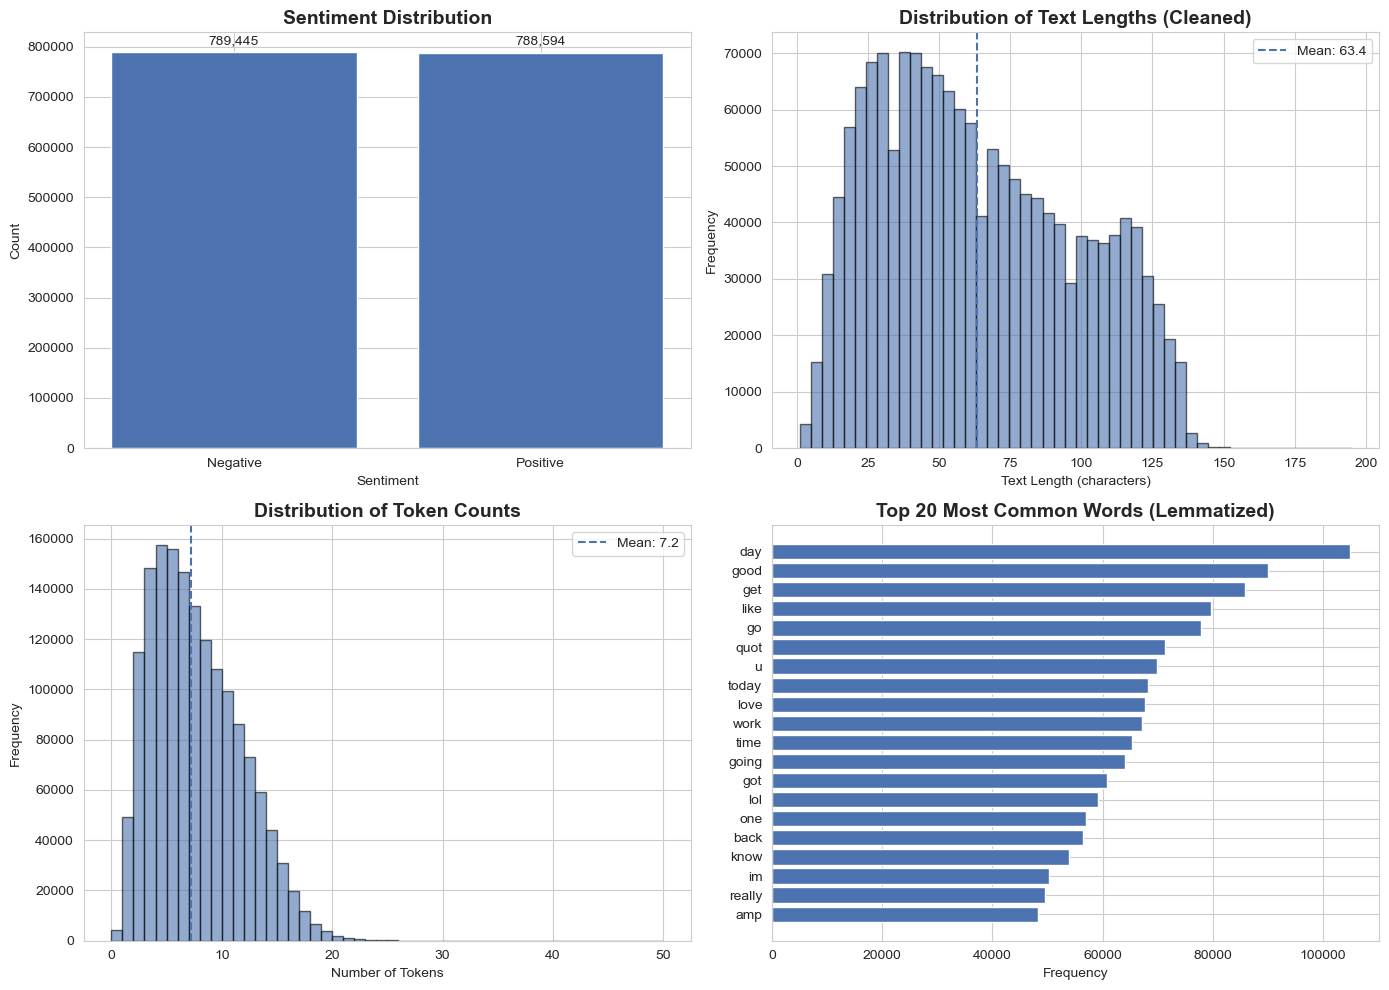


Top 20 most common words:
  day: 104,942
  good: 90,092
  get: 85,895
  like: 79,585
  go: 77,805
  quot: 71,374
  u: 69,942
  today: 68,203
  love: 67,769
  work: 67,176
  time: 65,304
  going: 64,063
  got: 60,748
  lol: 59,082
  one: 57,035
  back: 56,398
  know: 53,892
  im: 50,346
  really: 49,611
  amp: 48,262


In [94]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Ensure sentiment exists for plotting
if 'sentiment' not in df_cleaned.columns:
    df_cleaned['sentiment'] = df_cleaned['target'].apply(lambda x: 0 if x == 0 else 1)

# Single color
single_color = "#4C72B0"

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Sentiment Distribution
sentiment_counts = df_cleaned['sentiment'].value_counts()
axes[0, 0].bar(['Negative', 'Positive'], sentiment_counts.values, color=single_color)
axes[0, 0].set_title('Sentiment Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_xlabel('Sentiment')
for i, v in enumerate(sentiment_counts.values):
    axes[0, 0].text(i, v + 10000, f'{v:,}', ha='center', va='bottom')

# 2. Text Length Distribution
axes[0, 1].hist(text_lengths, bins=50, color=single_color, alpha=0.6, edgecolor='black')
axes[0, 1].set_title('Distribution of Text Lengths (Cleaned)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Text Length (characters)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(text_lengths.mean(), color=single_color, linestyle='--', label=f'Mean: {text_lengths.mean():.1f}')
axes[0, 1].legend()

# 3. Token Count Distribution
axes[1, 0].hist(token_counts, bins=50, color=single_color, alpha=0.6, edgecolor='black')
axes[1, 0].set_title('Distribution of Token Counts', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Number of Tokens')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(token_counts.mean(), color=single_color, linestyle='--', label=f'Mean: {token_counts.mean():.1f}')
axes[1, 0].legend()

# 4. Top 20 Most Common Words
all_tokens = [token for tokens in df_cleaned['tokens_lemmatized'] for token in tokens]
token_freq = Counter(all_tokens)
top_20 = dict(token_freq.most_common(20))
axes[1, 1].barh(list(top_20.keys()), list(top_20.values()), color=single_color)
axes[1, 1].set_title('Top 20 Most Common Words (Lemmatized)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Frequency')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.show()

print(f"\nTop 20 most common words:")
for word, count in token_freq.most_common(20):
    print(f"  {word}: {count:,}")

## 8. Data Splits (Train/Validation/Test)

Split 70/15/15 with stratification to preserve sentiment balance.

In [95]:
# Prepare the data for splitting
df_final = df_cleaned[['text', 'text_cleaned', 'text_processed', 'sentiment', 'tokens_lemmatized']].copy()

print("Original dataset shape:", df_final.shape)
print("\nSentiment distribution:")
print(df_final['sentiment'].value_counts(normalize=True))

# First split: 70% train, 30% temp (which will be split into validation and test)
X = df_final.drop('sentiment', axis=1)
y = df_final['sentiment']

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=0.30, 
    random_state=42, 
    stratify=y
)

# Second split: Split temp into 50% validation and 50% test (15% each of total)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, 
    test_size=0.50, 
    random_state=42, 
    stratify=y_temp
)

# Combine features and labels
train_df = pd.concat([X_train, y_train], axis=1)
val_df = pd.concat([X_val, y_val], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

# Build a single summary table for sizes + sentiment distribution
def _split_summary(name, df, total_rows):
    counts = df['sentiment'].value_counts().sort_index()
    neg = counts.get(0, 0)
    pos = counts.get(1, 0)
    return {
        "Split": name,
        "Samples": len(df),
        "Percent": len(df) / total_rows * 100,
        "Negative (0)": neg,
        "Negative %": neg / len(df) * 100 if len(df) else 0,
        "Positive (1)": pos,
        "Positive %": pos / len(df) * 100 if len(df) else 0,
    }

summary_df = pd.DataFrame([
    _split_summary("Train", train_df, len(df_final)),
    _split_summary("Validation", val_df, len(df_final)),
    _split_summary("Test", test_df, len(df_final)),
])

summary_df["Percent"] = summary_df["Percent"].map(lambda x: f"{x:.1f}%")
summary_df["Negative %"] = summary_df["Negative %"].map(lambda x: f"{x:.2f}%")
summary_df["Positive %"] = summary_df["Positive %"].map(lambda x: f"{x:.2f}%")

print("\n" + "="*80)
print("DATA SPLIT SUMMARY + SENTIMENT DISTRIBUTION")
print("="*80)
summary_df

Original dataset shape: (1578039, 5)

Sentiment distribution:
sentiment
1    0.50027
0    0.49973
Name: proportion, dtype: float64

DATA SPLIT SUMMARY + SENTIMENT DISTRIBUTION


,Split,Samples,Percent,Negative (0),Negative %,Positive (1),Positive %
0,Train,1104627,70.0%,552016,49.97%,552611,50.03%
1,Validation,236706,15.0%,118289,49.97%,118417,50.03%
2,Test,236706,15.0%,118289,49.97%,118417,50.03%


## 9. Save Processed Data

Save train/val/test splits and the full processed dataset to CSV.

In [96]:
# Save the processed datasets
train_df.to_csv('sentiment140_train.csv', index=False)
val_df.to_csv('sentiment140_val.csv', index=False)
test_df.to_csv('sentiment140_test.csv', index=False)

# Also save the complete processed dataset
df_final.to_csv('sentiment140_processed.csv', index=False)

print("Data saved successfully!")
print(f"\nFiles created:")
print(f"  - sentiment140_train.csv ({len(train_df):,} rows)")
print(f"  - sentiment140_val.csv ({len(val_df):,} rows)")
print(f"  - sentiment140_test.csv ({len(test_df):,} rows)")
print(f"  - sentiment140_processed.csv ({len(df_final):,} rows)")

Data saved successfully!

Files created:
  - sentiment140_train.csv (1,104,627 rows)
  - sentiment140_val.csv (236,706 rows)
  - sentiment140_test.csv (236,706 rows)
  - sentiment140_processed.csv (1,578,039 rows)
